<a href="https://colab.research.google.com/github/kozz84/particle_analysis/blob/main/Article_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import scipy
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns
import scipy.stats
from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb

Mounted at /content/drive


In [2]:
df = pd.read_csv("/content/drive/MyDrive/CIOP/images/df.csv")

In [3]:
df.head()

,mean_intensity,area,extent,eccentricity,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,...,convex_image,img,convex_perimeter,circularity,aspect_ratio,solidity,convexity,filename,area_fraction,label
0,44.255319,578.356287,0.380567,0.775433,892.145337,27.136435,40.826682,25.779193,125.667879,50.225669,...,[[False False True False False False False Fa...,"[array([[ 96, 97, 99, 95, 85, 93, 84, 8...",125.491598,0.678388,0.631430,0.648276,0.998597,210902_#1_50_10_1um_i004.tif,516.940327,0
1,13.791667,295.330870,0.500000,0.811877,393.774493,19.391414,28.140599,16.429302,84.262928,31.375727,...,[[False False False False False False False Fa...,"[array([[111, 113, 106, 111, 114, 105, 89, 10...",74.766633,0.722974,0.583829,0.750000,0.887302,210902_#1_50_10_1um_i004.tif,263.969529,0
2,16.066667,276.872691,0.441176,0.951442,430.690852,18.775656,40.863839,12.579055,83.059202,42.240865,...,[[False False False False True True True T...,"[array([[ 81, 83, 98, 93, 117, 114, 105, 9...",83.059202,0.710162,0.307829,0.642857,1.000000,210902_#1_50_10_1um_i004.tif,247.471433,0
3,34.584337,1021.352592,0.399038,0.834056,1839.665212,36.061427,63.447555,35.002771,232.166887,66.187168,...,[[False False False False False False False Fa...,"[array([[101, 109, 100, 95, 109, 116, 116, 11...",175.189118,0.487969,0.551680,0.555184,0.754583,210902_#1_50_10_1um_i004.tif,912.894621,0
4,15.392857,344.552682,0.388889,0.870760,584.509014,20.945121,36.982017,18.184369,107.526452,39.996361,...,[[False False False False False False True T...,"[array([[109, 109, 117, 110, 109, 98, 108, 11...",93.759223,0.611952,0.491708,0.589474,0.871964,210902_#1_50_10_1um_i004.tif,307.964450,0


In [4]:
skew = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
skew['skew'] = scipy.stats.skew(df.select_dtypes(np.number))
skew['skew_abs'] = skew['skew'].apply(abs)
skew['skewed'] = skew['skew_abs'].apply(lambda x: True if x>=0.5 else False)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocessing(df):
    temp = df[(df['equivalent_diameter']>0)].copy()
    temp = temp[temp['filename']!= '210902_#9_150_30_1um_i005']
    file_col = pd.DataFrame(columns=['filename'])
    file_col['filename'] = temp['filename'].copy()
    for column in skew.query('skewed == True')['Feature'].values:
        temp[column] = np.log1p(temp[column])
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    check = X.copy()
    X_df = X.copy()
    scaler = StandardScaler()
    columns_names = X.columns
    X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    return X,y,X_train,X_test,y_train,y_test, file_col,columns_names,X_df, check
X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df, check = preprocessing(df)

In [23]:
check

,mean_intensity,area,extent,eccentricity,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,convex_perimeter,circularity,aspect_ratio,solidity,convexity,area_fraction
0,3.812320,6.361918,0.380567,0.574044,6.794749,3.337065,3.733534,3.287625,4.841569,3.936241,4.840176,0.678388,0.631430,0.499730,0.692446,6.249860
1,2.694064,5.691477,0.500000,0.594363,5.978315,3.015114,3.372132,2.858153,4.445740,3.477409,4.327658,0.722974,0.583829,0.559616,0.635148,5.579615
2,2.837127,5.627163,0.441176,0.668569,6.067710,2.984452,3.734422,2.608529,4.431521,3.766786,4.431521,0.710162,0.307829,0.496437,0.693147,5.515328
3,3.571906,6.929862,0.399038,0.606530,7.517882,3.612577,4.165852,3.583596,5.451754,4.207482,5.171558,0.487969,0.551680,0.441594,0.562231,6.817715
4,2.796846,5.845145,0.388889,0.626345,6.372482,3.088545,3.637113,2.954096,4.686994,3.713483,4.551339,0.611952,0.491708,0.463403,0.626988,5.733226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11593,4.216389,6.261457,0.544872,0.593088,6.580457,3.288576,3.615260,3.101328,4.706548,3.682513,4.596314,0.739201,0.587026,0.546094,0.639046,6.231954
11594,3.995054,6.109579,0.304167,0.677222,6.491242,3.215426,4.005332,2.669982,4.838203,3.953859,4.739296,0.599859,0.249391,0.520128,0.644521,6.080085
11595,3.789987,5.581868,0.558442,0.632443,5.845145,2.962882,3.371672,2.656349,4.287337,3.358028,4.251403,0.803369,0.470868,0.569768,0.675091,5.552421
11596,4.251348,6.067710,0.432099,0.662517,6.597384,3.195294,3.921064,2.885777,4.724946,3.834371,4.691716,0.658476,0.342084,0.462624,0.676522,6.038219


In [6]:
from sklearn.cluster import SpectralClustering, KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

In [15]:
cluster_models = {
    'Spectral Clustering':SpectralClustering(n_clusters=2,
                            affinity='nearest_neighbors',
                            assign_labels='kmeans',
                            random_state=464
                            ),
    'Spectral Biclustering': KMeans(n_clusters=2),
    'AgglomerativeClustering':AgglomerativeClustering(),
    "DBSCAN":DBSCAN(eps=9.7, min_samples=2, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
}

cluster_score = []
cluster_results = pd.DataFrame()
cluster_results['true'] = y
for name,cluster_model in cluster_models.items():
    cluster_model.fit(X)
    print(confusion_matrix(y,cluster_model.labels_))
    cluster_score.append([name,accuracy_score(y,cluster_model.labels_)])
    cluster_results[name] = cluster_model.labels_
cluster_score = pd.DataFrame(cluster_score, columns=['model name', 'Accuracy'])
cluster_score.sort_values('Accuracy',ascending=False)

[[1488 4437]
 [1649 4024]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1847 4078]
 [1896 3777]]
[[2411 3514]
 [2240 3433]]
[[5925    0]
 [5673    0]]


,model name,Accuracy
3,DBSCAN,0.510864
2,AgglomerativeClustering,0.503880
1,Spectral Biclustering,0.484911
0,Spectral Clustering,0.475254


In [8]:
def NN_model():
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'adam',
                loss='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min',
                            verbose=1,
                            patience=25)
    return model
y.value_counts()

0    5925
1    5673
Name: label, dtype: int64

In [20]:
X.shape

(11598, 16)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

In [ ]:
for i in range (10):
    X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df = preprocessing(df)
    NN_model()
    model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)
    y_pred = pd.DataFrame((model.predict(X) > 0.5).astype("int32"))
    print(i,accuracy_score(y,y_pred))
    print(confusion_matrix(y,y_pred))

In [12]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)
model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)

Epoch 134: early stopping


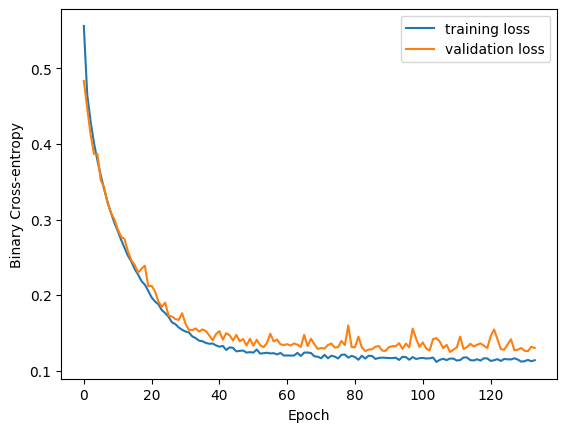

In [13]:
history = pd.DataFrame(model.history.history)
plt.plot(history)
plt.ylabel('Binary Cross-entropy')
plt.xlabel('Epoch')
plt.gca().legend(('training loss','validation loss'))

In [14]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

109/109 [==============================] - 0s 1ms/step
0.9508620689655173
[[1730   57]
 [ 114 1579]]
F1 Score: 0.949
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1787
           1       0.97      0.93      0.95      1693

    accuracy                           0.95      3480
   macro avg       0.95      0.95      0.95      3480
weighted avg       0.95      0.95      0.95      3480



In [24]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
models = {
    'K-Neighbors Classifier':KNeighborsClassifier(),
          'Logistic Regression':LogisticRegression(max_iter=500),
          'SVC': SVC(),
         'Decision Tree Classifier':DecisionTreeClassifier(),
          'Random Forest Classifier':RandomForestClassifier(),
      #    'Ad aBoost Classifier':AdaBoostClassifier(),
        #  'Gaussian NB':GaussianNB()
         }
score = []
x=0
#results = pd.DataFrame(y_test)
for name,model in models.items():
    x+=1
    #model.fit(X,y)
   # y_pred = model.predict(X_test)
    cvs = cross_val_score(estimator= model,X=X,y=y,cv=10)
    acc = cvs.mean()
    std = cvs.std()
    #score.append([name,accuracy_score(y_test,y_pred)])
    print(x,'/',len(models),name,round(acc,3),round(std,3))
    #y_pred = cross_val_predict(model, X=X, y=y, cv=10)
    #print(confusion_matrix(y, y_pred)) 
    score.append([name,acc, std])

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(confusion_matrix(y_test, y_pred)) 
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    classification_report
    #results[name] = y_pred
score = pd.DataFrame(score, columns=['model name', 'Accuracy','std'])

1 / 5 K-Neighbors Classifier 0.875 0.015
K-Neighbors Classifier
[[1598  193]
 [ 269 1420]]
F1 Score: 0.860
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1791
           1       0.88      0.84      0.86      1689

    accuracy                           0.87      3480
   macro avg       0.87      0.87      0.87      3480
weighted avg       0.87      0.87      0.87      3480

2 / 5 Logistic Regression 0.924 0.053
Logistic Regression
[[1687  104]
 [ 166 1523]]
F1 Score: 0.919
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1791
           1       0.94      0.90      0.92      1689

    accuracy                           0.92      3480
   macro avg       0.92      0.92      0.92      3480
weighted avg       0.92      0.92      0.92      3480

3 / 5 SVC 0.909 0.019
SVC
[[1673  118]
 [ 239 1450]]
F1 Score: 0.890
              precision    recall  f1-score   support

           0  